### Study on bias and interpretable models - SCHOOL PROJECT
*Nathan Lauga - December 2018*

*****

Hello world ! ✋



## Table of content

* [1. Load and prepare data](#1)
    * [1.1 Load libraries](#1.1)
    * [1.2 Load the data](#1.2)
    * [1.3 Quick EDA](#1.3)
    * [1.4 Work with feature](#1.4)
* 2. [AIF360 Introduction](#2)
    * [2.1 Create dataset using aif360](#2.1)
    * [2.2 Quick look on the dataset](#2.2)
    * [2.3 First model](#2.3)
* 3. [Bias and Fairness](#3)
    * [3.1 Metrics](#3.1)
        * [3.1.1 Statistical Parity Difference](#3.1.1)
        * [3.1.2 Equal Opportunity Difference](#3.1.2)
        * [3.1.3 Average Absolute Odds Difference](#3.1.3)
        * [3.1.4 Disparate Impact](#3.1.4)
        * [3.1.5 Theil Index](#3.1.5)
    * [3.2 How to fix it ?](#3.2)
        * [3.2.1 Pre-processing algorithms](#3.2.1)
            * [3.2.1.1 Disparate impact remove](#3.2.1.1)
            * [3.2.1.2 Learning fair representations](#3.2.1.2)
            * [3.2.1.3 Optimized preprocessing](#3.2.1.3)
            * [3.2.1.4 Reweighing](#3.2.1.4)
        * [3.2.2 In-processing algorithms](#3.2.2)
            * [3.2.2.1 Adversarial Debiasing](#3.2.2.1)
            * [3.2.2.2 Prejudice Remover Regularizer](#3.2.2.2)
        * [3.2.3 Post-processing algorithms](#3.2.3)
            * [3.2.3.1 Calibrated Equality of Odds](#3.2.3.1)
            * [3.2.3.2 Equality of Odds](#3.2.3.2)
            * [3.2.3.3 Reject Option Classification](#3.2.3.3)
    * [3.3 Compare all the algorithms for one attribute](#3.3)
    * [3.4 Find the fairest algorithm](#3.4)
    * [3.5 Compare algorithms performance](#3.5)
* 4. [Interpretable model](#4)
    * [4.1 Feature importance](#4.1)
        * [4.1.1 Linear Regression](#4.1.1)
        * [4.1.2 Decision Tree](#4.1.2)
        * [4.1.3 Tree models (e.g Random Forest)](#4.1.3)
    * [4.2 LIME](#4.2)
    * [4.3 SHAP](#4.3)
        * [4.3.1 Shapley Values](#4.3.1)
        * [4.3.2 How SHAP works](#4.3.2)
        * [4.3.3 SHAP in Python](#4.3.3)
    * [4.4 Compare importance](#4.4)

## <a id='1'>1. Load and prepare data</a>

### <a id='1.1'>1.1 Load libraries</a>

In [1]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Custom visualisation functions in visualitions.py file
from visualisations import plot_fair_metrics, plot_bar, plot_histo, plot_model_performance,\
                        plot_fair_metrics_plotly, plot_score_fair_metrics, plot_lime_importance,\
                        plot_compare_model_performance, plot_global_importance_lime

# Custom metrics functions in metrics.py file
from metrics import fair_metrics, get_model_performance, score_fair_metrics, score_all_attr

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

import lime
import lime.lime_tabular
import shap

# ML libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

### <a id='1.2'>1.2 Load the data</a>

I choose to use the Adult dataset that you can find on the following link : [UCI Machine Learning Repository : Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult)

In [2]:
cols = ["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]
data = pd.read_csv('./data/adult.csv', header=None)
data.columns = cols

### <a id='1.3'>1.3 Quick EDA</a>

In [3]:
data.head()

Age          Workclass  Final Weight   Education  Education-Num  \
0   39          State-gov         77516   Bachelors             13   
1   50   Self-emp-not-inc         83311   Bachelors             13   
2   38            Private        215646     HS-grad              9   
3   53            Private        234721        11th              7   
4   28            Private        338409   Bachelors             13   

        Marital Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital Gain  Capital Loss  Hours per week         Country  Income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

Since Education-Num is the same as Education but classed by number we can drop it

In [4]:
data.drop(columns=['Education-Num'], inplace=True)

In [5]:
na_count = pd.DataFrame(data.apply(lambda x : x.isna()).sum()).transpose()
na_count

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0    0          0             0          0               0           0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0             0     0    0             0             0               0   

   Country  Income  
0        0       0

This dataset doesn't have any NA value so we don't have to work with that.

#### Continuous columns

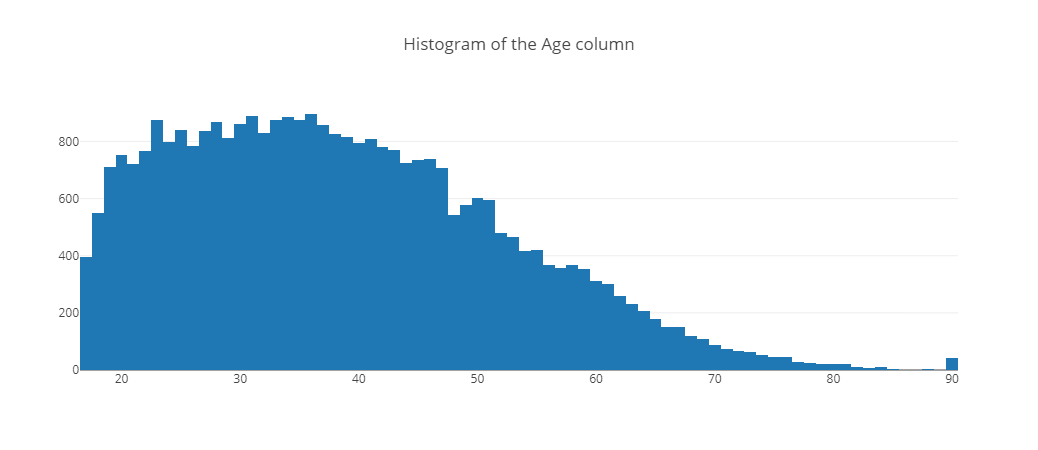

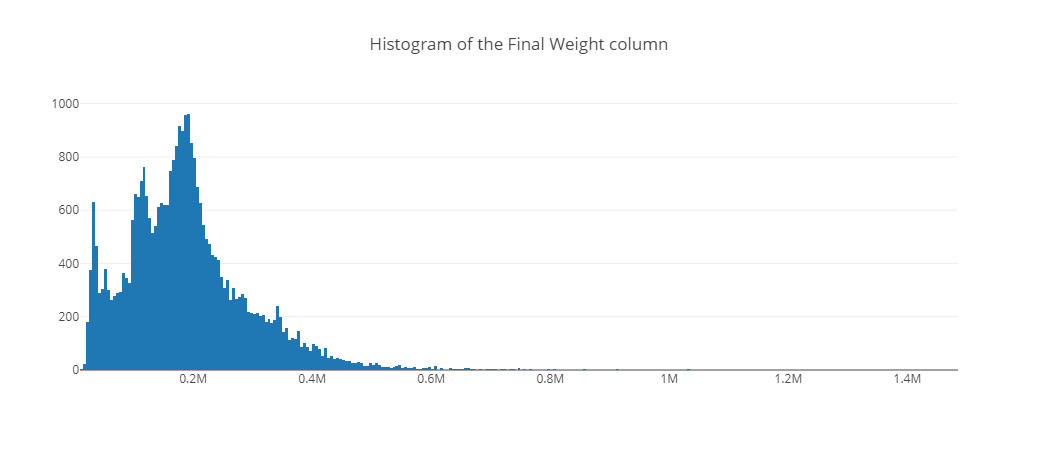

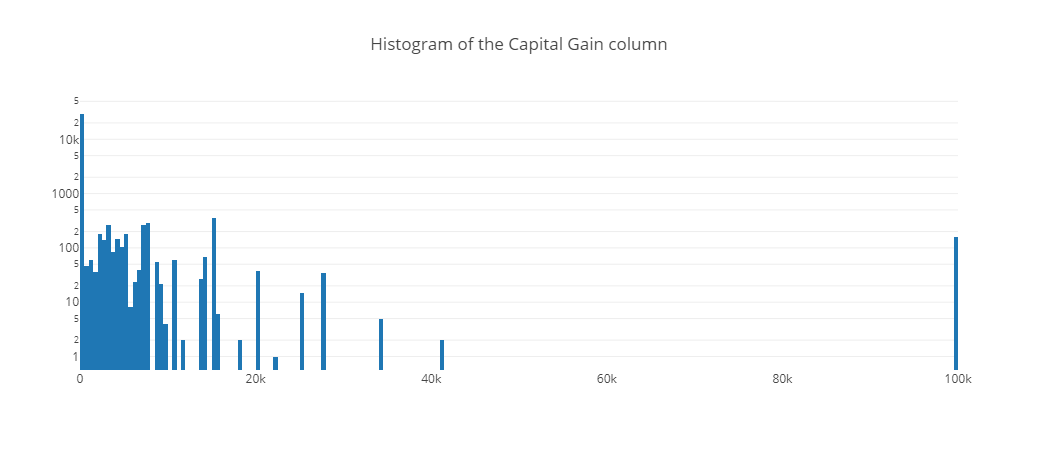

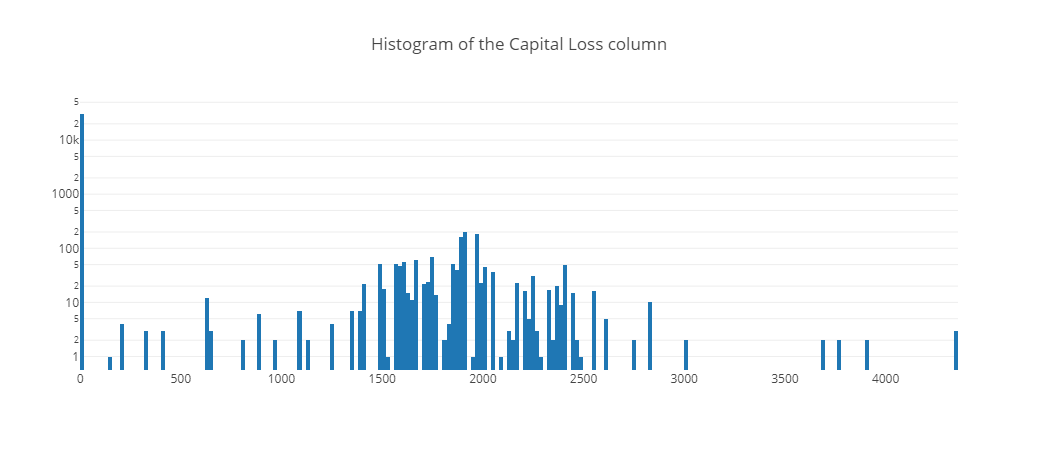

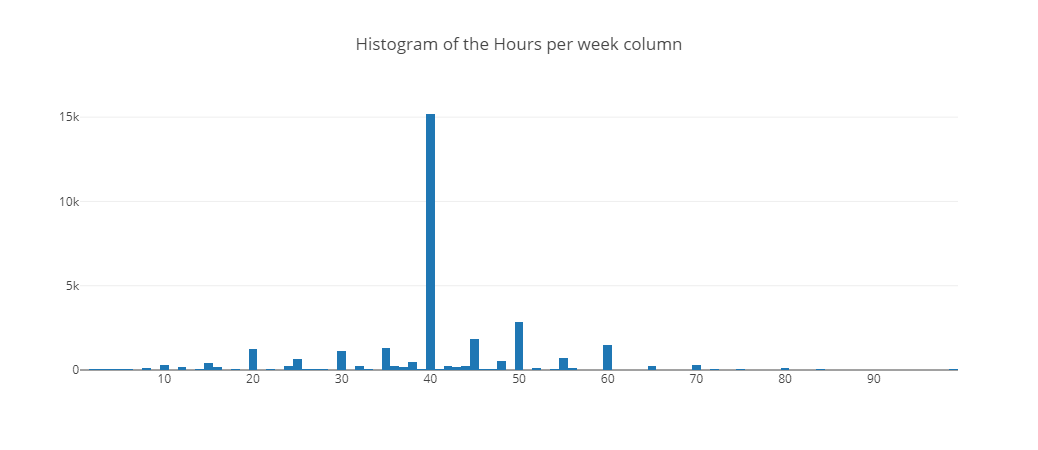

In [6]:
# print(data.columns.values)
display(Markdown('#### Continuous columns'))
plot_histo(data, 'Age')
plot_histo(data, 'Final Weight')
plot_histo(data, 'Capital Gain', type='log')
plot_histo(data, 'Capital Loss', type='log')
plot_histo(data, 'Hours per week')

#### Categorical columns

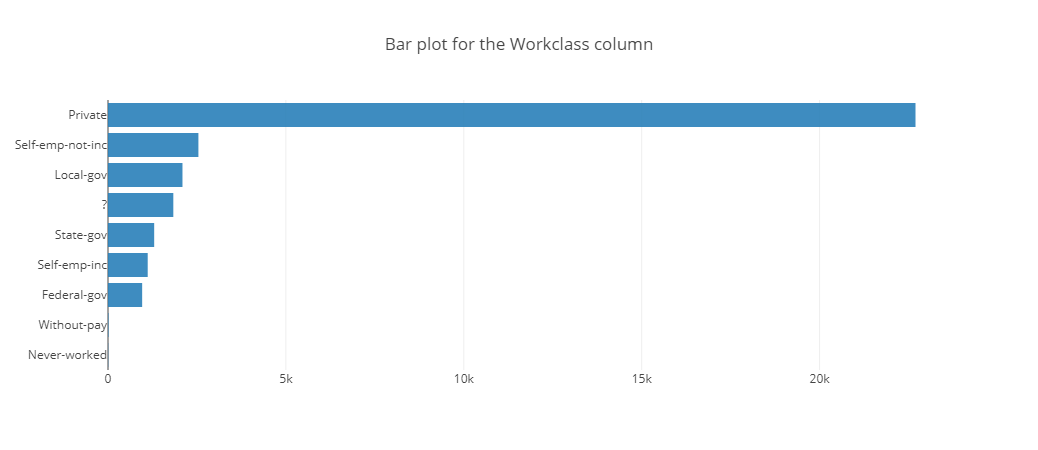

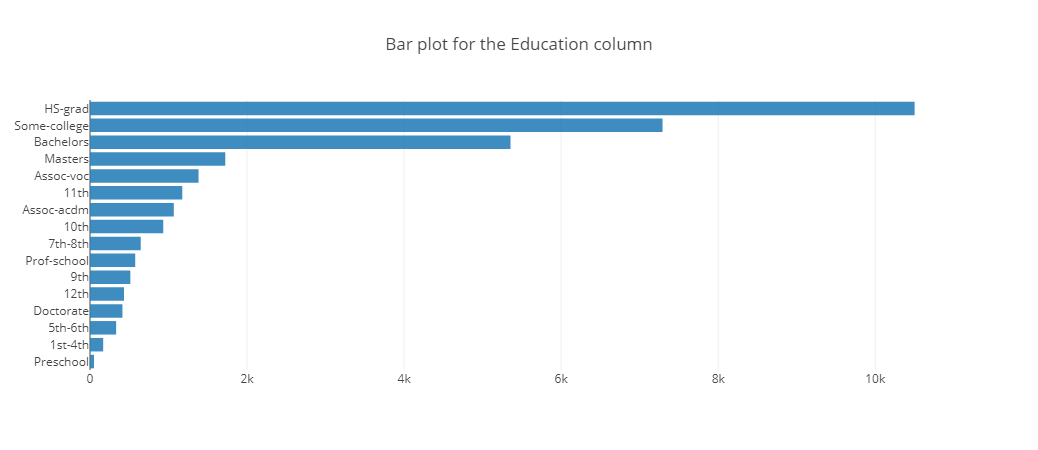

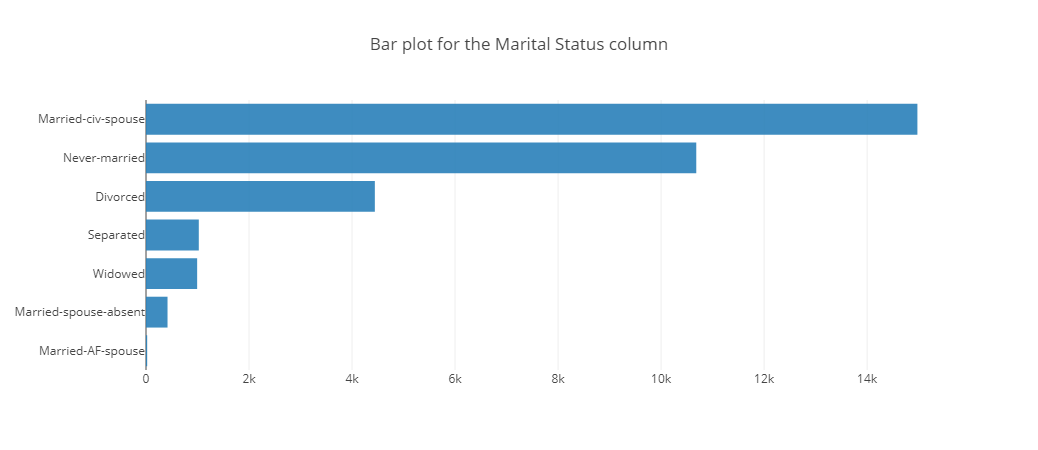

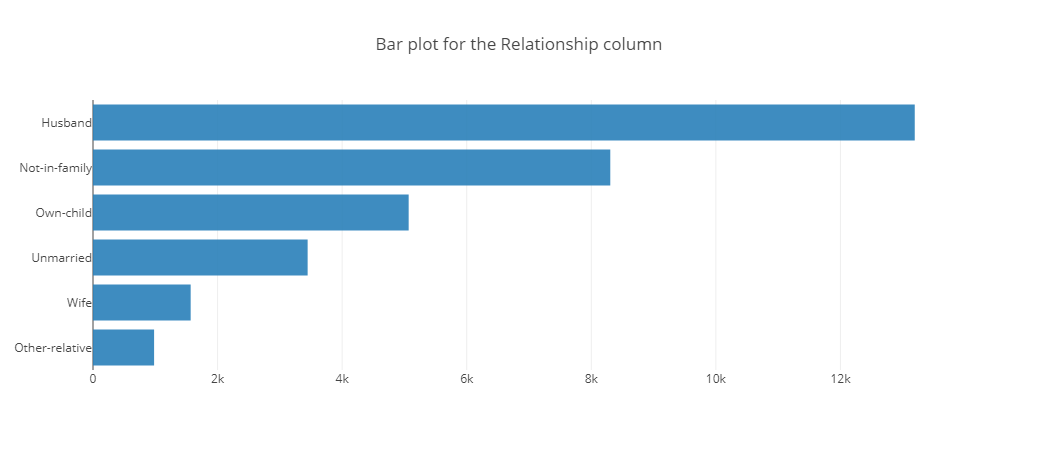

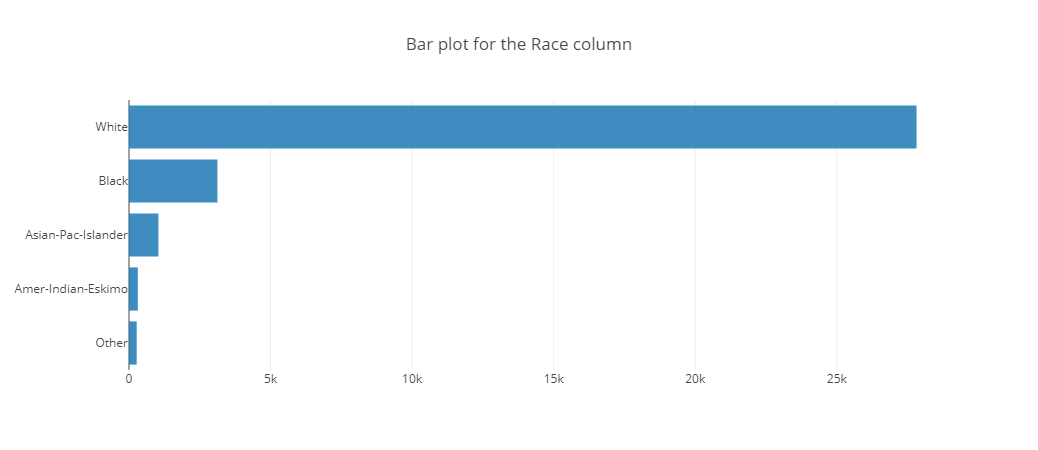

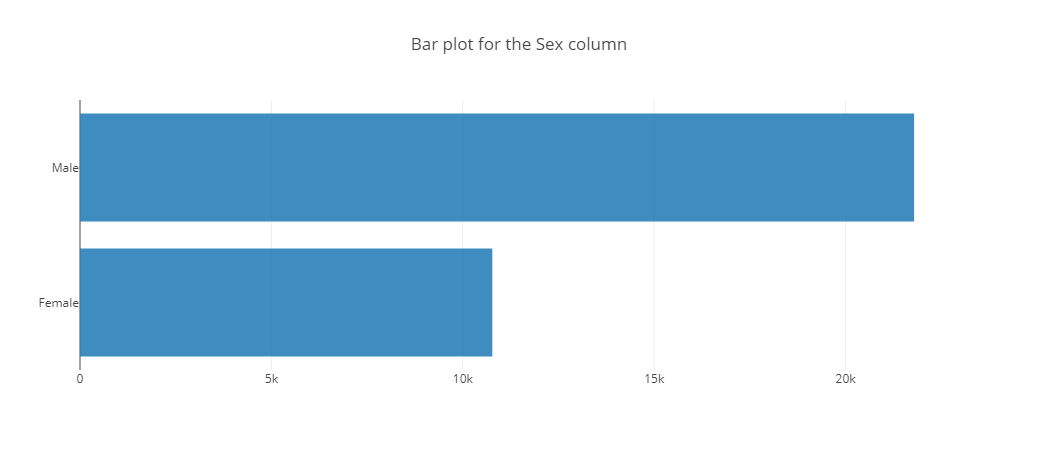

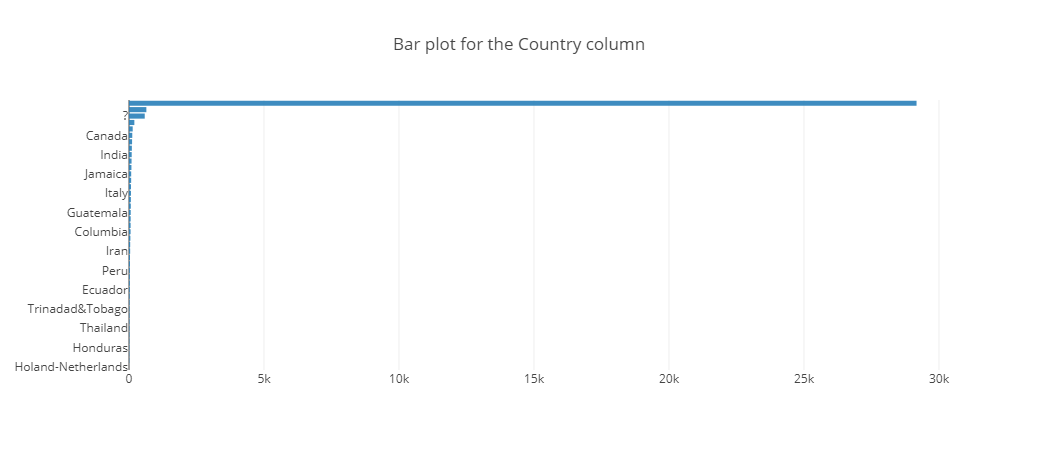

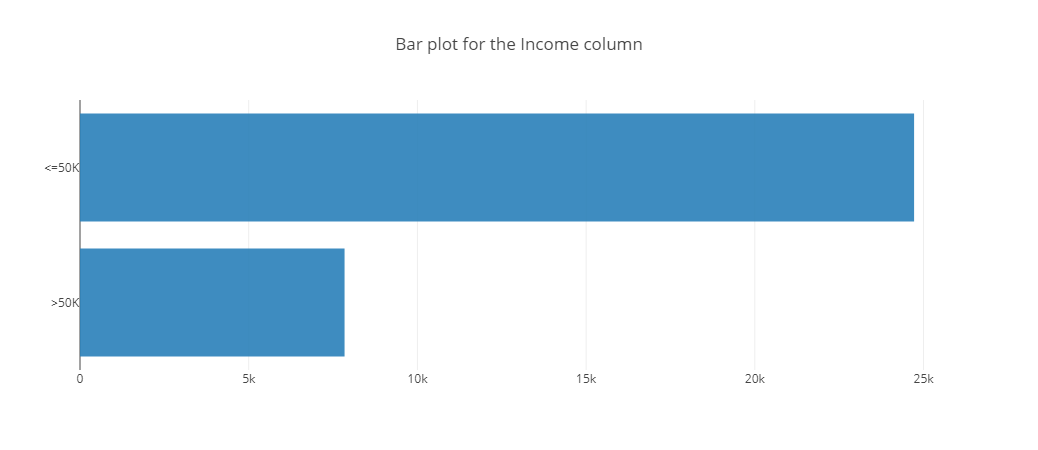

In [7]:
display(Markdown('#### Categorical columns'))
plot_bar(data, 'Workclass')
plot_bar(data, 'Education')
plot_bar(data, 'Marital Status')
plot_bar(data, 'Relationship')
plot_bar(data, 'Race')
plot_bar(data, 'Sex')
plot_bar(data, 'Country')
plot_bar(data, 'Income')

### <a id='1.4'>1.4 Work with feature</a>

#### Encoding categorical columns

*Why encoding and not dummies ?*

Later in the notebook I will use lime and shap libraries to interpret the model but with dummies values it just get the data to be incoherent (I will explain it later).

In [8]:
categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country", "Income"]
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

In [9]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

#### Scale numerical columns

I choose to scale these columns because later in this notebook I will use a neural network so it's necessary to use it.

In [10]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

In [11]:
data_encoded.head()

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0  0.301370        7.0      0.044302        9.0             4.0         1.0   
1  0.452055        6.0      0.048238        9.0             2.0         4.0   
2  0.287671        4.0      0.138113       11.0             0.0         6.0   
3  0.493151        4.0      0.151068        1.0             2.0         6.0   
4  0.150685        4.0      0.221488        9.0             2.0        10.0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0           1.0   4.0  1.0       0.02174           0.0        0.397959   
1           0.0   4.0  1.0       0.00000           0.0        0.122449   
2           1.0   4.0  1.0       0.00000           0.0        0.397959   
3           0.0   2.0  1.0       0.00000           0.0        0.397959   
4           5.0   2.0  0.0       0.00000           0.0        0.397959   

   Country  Income  
0     39.0     0.0  
1     39.0     0.0  
2     39.0     0.0  
3     39.0     0.0  
4      5.0     0.0

## <a id='2'>2. AIF360 Introduction</a>
### <a id='2.1'>2.1 Create dataset using aif360</a>

In [12]:
privileged_sex = np.where(categorical_names['Sex'] == ' Male')[0]
privileged_race = np.where(categorical_names['Race'] == ' White')[0]

In [13]:
data_orig = StandardDataset(data_encoded, 
                           label_name='Income', 
                           favorable_classes=[1], 
                           protected_attribute_names=['Sex', 'Race'], 
                           privileged_classes=[privileged_sex, privileged_race])

### <a id='2.2'>2.2 Quick look on the dataset</a>

In [14]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(data_orig.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(data_orig.favorable_label, data_orig.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(data_orig.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(data_orig.privileged_protected_attributes, data_orig.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(data_orig.feature_names)

#### Dataset shape

(32561, 13)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Sex', 'Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([4.])] [array([0.]), array([0., 1., 2., 3.])]


#### Dataset feature names

['Relationship', 'Race', 'Sex', 'Education', 'Workclass', 'Occupation', 'Country', 'Hours per week', 'Marital Status', 'Capital Gain', 'Final Weight', 'Age', 'Capital Loss']


### <a id='2.3'>2.3 First model</a>

#### Split into train and test set

In [15]:
np.random.seed(42)

data_orig_train, data_orig_test = data_orig.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print(data_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(data_orig_test.features.shape)

#### Train Dataset shape

(22792, 13)


#### Test Dataset shape

(9769, 13)


#### Training the model : classic Random Forest 

In [16]:
def train_model(model, dataset):
    X_train = dataset.features
    y_train = dataset.labels.ravel()
    
    # Train the model
    model.fit(X_train, y_train, sample_weight=dataset.instance_weights)
    
    return model

# Model to learn
rf = RandomForestClassifier(n_estimators=100)

# Train and save the model
rf_orig = train_model(rf, data_orig_train)

#### Predict on test set

In [17]:
X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

Now we have a model (Random forest) that is trained with the training dataset and the prediction of the test set. So in a first place let's check the performance of our model (accuracy, F1 Score, confusion matrix, ...).

#### Performance of the model

#### Accuracy of the model :

0.8597604667826799


#### F1 score of the model :

0.6821345707656612


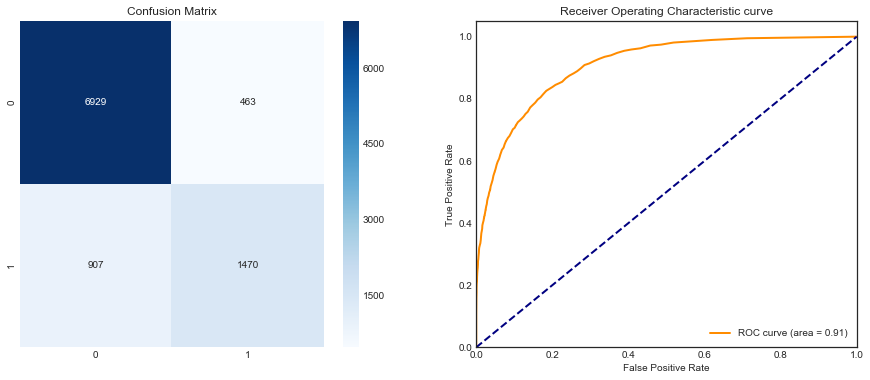

In [18]:
plot_model_performance(rf_orig, data_orig_test.features, y_test)

## <a id='3'>3. Bias and Fairness</a>

Today, a problem of the model that can be produce by Machine Learning is bias that data can have. So a question is how to measure those bias and how to avoid them. In python there is a package produced by IBM called [aif360](https://github.com/IBM/AIF360) that can gives us some metrics and algorithms to know if our data / model are bias and to get a fair model.

### <a id='3.1'>3.1 Metrics</a>

So with aif360 we have some metrics that indicate if our data or model are bias. I will use 5 metrics : 
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### <a id='3.1.1'>3.1.1 Statistical Parity Difference</a>

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

Here the bias or *statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

So it has to be close to **0** so it will be fair.

Also you can find more details about that here : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### <a id='3.1.2'>3.1.2 Equal Opportunity Difference</a>

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula :

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Same as the previous metric we need it to be close to **0**.

#### <a id='3.1.3'>3.1.3 Average Absolute Odds Difference</a>

This measure is using both false positive rate and true positive rate to calculate the bias. It's calculating the equality of odds with the next formula :

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

It needs to be equal to **0** to be fair.

#### <a id='3.1.4'>3.1.4 Disparate Impact</a>

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

It changes the objective, for the disparate impact it's **1** that we need.

#### <a id='3.1.5'>3.1.5 Theil Index</a>

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1 (more informations on [the Wikipedia page](https://en.wikipedia.org/wiki/Generalized_entropy_index)). So we can calculate it with this formula :

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

So it needs to be close to **0** to be fair.


With these differents metrics we can see that for some we need the prediction and for others just the original dataset. This is why we will use 2 classes of the aif360 package : `ClassificationMetric` and `BinaryLabelDatasetMetric`. 

For the first one we need the prediction so we can have the following metrics : 
* Equal Opportunity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference)
   
`equal_opportunity_difference()`
* Average Absolute Odds Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference)

`average_abs_odds_difference()`
* Theil Index : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index)

`theil_index()`

Then for the metrics that don't require prediction (the second class) we can use them with the following functions : 
* Statistical Parity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference)

`statistical_parity_difference()`
* Disparate Impact : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact)

`disparate_impact()`


Now I construct a `DataFrame` that will keep the values of the differents metrics I talked just above with a function. 

In [19]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Sex attribute :

With default thresholds, bias against unprivileged group detected in **3** out of 5 metrics

#### For the Race attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
Sex                            -0.180359                     -0.105927   
Race                           -0.164482                     -0.514932   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000     0.000000  
Sex                           0.089502          0.299889     0.115347  
Race                          0.271261          0.230907     0.115347

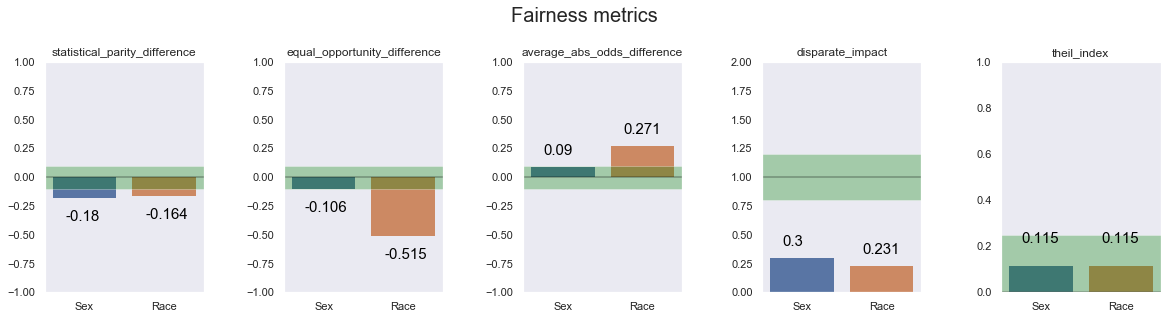

In [20]:
fair = get_fair_metrics_and_plot(data_orig_test, rf_orig)

In [21]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [22]:
probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

### <a id='3.2'>3.2 How to fix it ?</a>

AIF360 use 3 types of algorithms :
* Pre-processing algorithms : they are used before training the model
* In-processing algorithms : they are fair classifiers so it's during the training
* Post-processing algorithms : they are used after training the model

![Fairness pipeline](http://image.noelshack.com/fichiers/2018/50/1/1544437769-fairness-pipeline.png)

This is the **fairness pipeline**. An example instantiation of this generic pipeline consists of loading data into a dataset object, transforming
it into a fairer dataset using a fair pre-processing algorithm, learning a classifier from this transformed dataset, and obtaining
predictions from this classifier. Metrics can be calculated on the original, transformed, and predicted datasets as well as between the
transformed and predicted datasets. Many other instantiations are also possible (more information on [the aif360 paper](https://arxiv.org/pdf/1810.01943.pdf)).

#### <a id='3.2.1'>3.2.1 Pre-processing algorithms </a>

There are 4 pre-processing algorithms but for 3 of them **there is a problem** : it will work only if the dataset have one protected attribute but here we have 2 : *Sex* and *Race*. But let's have a quick intro for all of them and at the end I will use the one that work for my case.

Because this notebook is an exploration of fairness into models I will only use 1 protected attribute : Sex, it will allow me to use almost all the algorithms (but for your information the *Reweighing* algo can works with all protected so that's why I will create a function that gives me the protected and unprotected attributes.

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#)



In [23]:
def get_attributes(data, only_one=True):
    unprivileged_groups = []
    privileged_groups = []
    
    for attr in data.protected_attribute_names:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 
            if only_one:
                break

    return privileged_groups, unprivileged_groups

*****
##### <a id='3.2.1.1'>3.2.1.1 Disparate impact remover</a>
Source : [Feldman et al., 2015](https://dl.acm.org/citation.cfm?doid=2783258.2783311)

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups.
If you want to see how it works you can take a look on [an example Notebook from the GitHub of AIF360](https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).

Some code example :
```
from aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover()
data_transf_train = DIR.fit_transform(data_orig_train)
```
*****
##### <a id='3.2.1.2'>3.2.1.2 Learning fair representations</a>
Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.
You can find more information on [the demo notebook](https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

In [24]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

LFR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR.fit_transform(data_orig_train)

# Train and save the model
rf_transf = train_model(rf, data_transf_train)

data_transf_test = LFR.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)

# algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, 'LFR')

250 36386.97659434254
500 33768.249868675965
750 33373.503364711316
1000 33359.4792132479
1250 33359.47903875777
1500 33359.46800383608
1750 33374.22724871893
2000 33730.847011175196
2250 33359.47914104997
2500 33359.47816673035


*****
##### <a id='3.2.1.3'>3.2.1.3 Optimized preprocessing</a>
Source : [Calmon et al., 2017](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention)

Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.
There is also [a demo notebook on the aif360 GitHub](https://github.com/IBM/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb).

*To be honest I tried to work with this one but it's more complicated : it uses options that you have to configure yourself and I don't really find how to choose it. Also it use an Optimizer and I didn't find how to build this class. (I didn't read the paper about this algorithm)*
*****
##### <a id='3.2.1.4'>3.2.1.4 Reweighing</a>
Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

In [25]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=False)

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = train_model(rf, data_transf_train)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')

#### <a id='3.2.2'>3.2.2 In-processing algorithms</a>

It exists 3 in-processing algorithms with aif360. But **I will only use 2** : *Adversarial Debiasing* wich is using TensorFlow and *Prejudice Remover Regularizer*. I'm not using the last one : *ART Classifier*, because I didn't found any documentation that show how it works (maybe I didn't search enough 🙄).

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/inprocessing.html)
*****
#####  <a id='3.2.2.1'>3.2.2.1 Adversarial Debiasing</a>
Source : [Zhang et al., 2018](http://www.aies-conference.com/wp-content/papers/main/AIES_2018_paper_162.pdf)

Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.

In [26]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

# sess.close()
# tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=42,
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')

epoch 0; iter: 0; batch classifier loss: 2.965416; batch adversarial loss: 0.770843
epoch 1; iter: 0; batch classifier loss: 0.581300; batch adversarial loss: 0.643030
epoch 2; iter: 0; batch classifier loss: 0.555311; batch adversarial loss: 0.654892
epoch 3; iter: 0; batch classifier loss: 0.454433; batch adversarial loss: 0.610805
epoch 4; iter: 0; batch classifier loss: 0.501765; batch adversarial loss: 0.573849
epoch 5; iter: 0; batch classifier loss: 0.469261; batch adversarial loss: 0.646284
epoch 6; iter: 0; batch classifier loss: 0.453116; batch adversarial loss: 0.636764
epoch 7; iter: 0; batch classifier loss: 0.428364; batch adversarial loss: 0.613956
epoch 8; iter: 0; batch classifier loss: 0.450369; batch adversarial loss: 0.636889
epoch 9; iter: 0; batch classifier loss: 0.450490; batch adversarial loss: 0.690079
epoch 10; iter: 0; batch classifier loss: 0.429589; batch adversarial loss: 0.593351
epoch 11; iter: 0; batch classifier loss: 0.447281; batch adversarial loss:

*****
##### <a id='3.2.2.2'>3.2.2.2 Prejudice Remover Regularizer</a>
Source : [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

In [27]:
debiased_model = PrejudiceRemover(sensitive_attr="Sex", eta = 25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')

#### <a id='3.2.3'>3.2.3 Post-processing algorithms</a>

It exists 3 post-processing algorithms with aif360. 

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/postprocessing.html)

I prepare the predict dataset for all the algorithms that require a dataset with predict scores and labels.

In [28]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

*****
##### <a id='3.2.3.1'>3.2.3.1 Calibrated Equality of Odds</a>
Source : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

In [29]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      CPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'CalibratedEqOdds')

*****
##### <a id='3.2.3.2'>3.2.3.2 Equality of Odds</a>
Source : [Hardt et al., 2016](https://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning)

Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds.

In [30]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups,
                             seed=42)

EOPP = EOPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = EOPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      EOPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'EqOdds')

*****
##### <a id='3.2.3.3'>3.2.3.3 Reject Option Classification</a>
Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [31]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      ROC, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'RejectOption')

### <a id='3.3'>3.3 Compare all the algorithms for one attribute</a>

In [32]:
def compare_fair_metrics(algo_metrics, attr='Sex'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score)

statistical_parity_difference  equal_opportunity_difference  \
Origin                                -0.180359                     -0.105927   
Reweighing                            -0.182196                     -0.107765   
AdvDebiasing                           0.006422                      0.369007   
PrejudiceRemover                      -0.163178                     -0.263306   
CalibratedEqOdds                      -0.182196                     -0.107765   
EqOdds                                -0.023513                      0.152644   
RejectOption                          -0.048518                      0.217100   

                  average_abs_odds_difference  disparate_impact  theil_index  
Origin                               0.089502          0.299889     0.115347  
Reweighing                           0.090927          0.297766     0.114269  
AdvDebiasing                         0.193004          1.051796     0.181249  
PrejudiceRemover                     0.174202          0.088076     0.189803  
CalibratedEqOdds                     0.090927          0.297766     0.114269  
EqOdds                               0.093352          0.867461     0.162198  
RejectOption                         0.112098          0.703767     0.144114

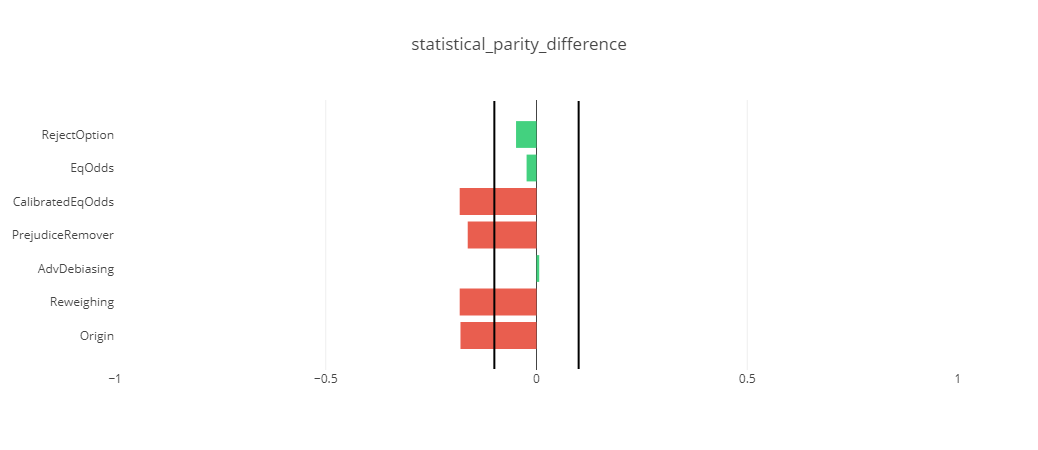

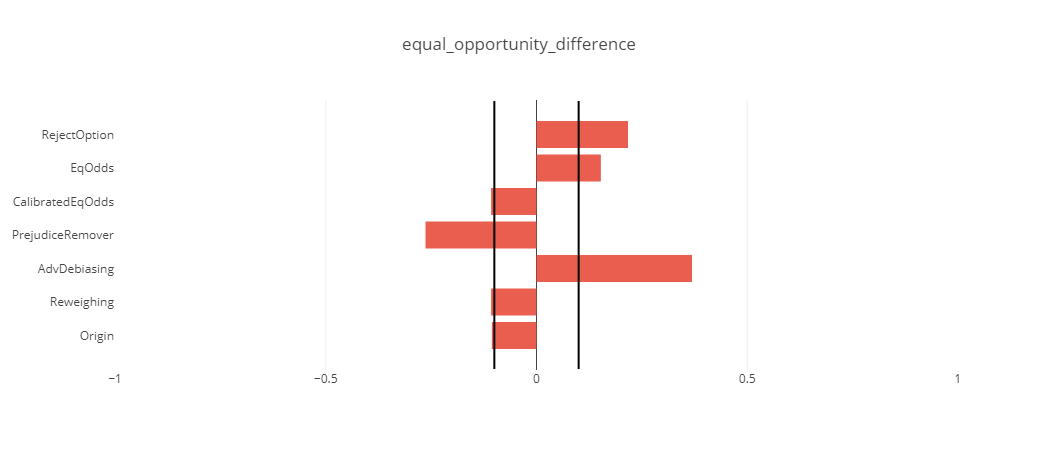

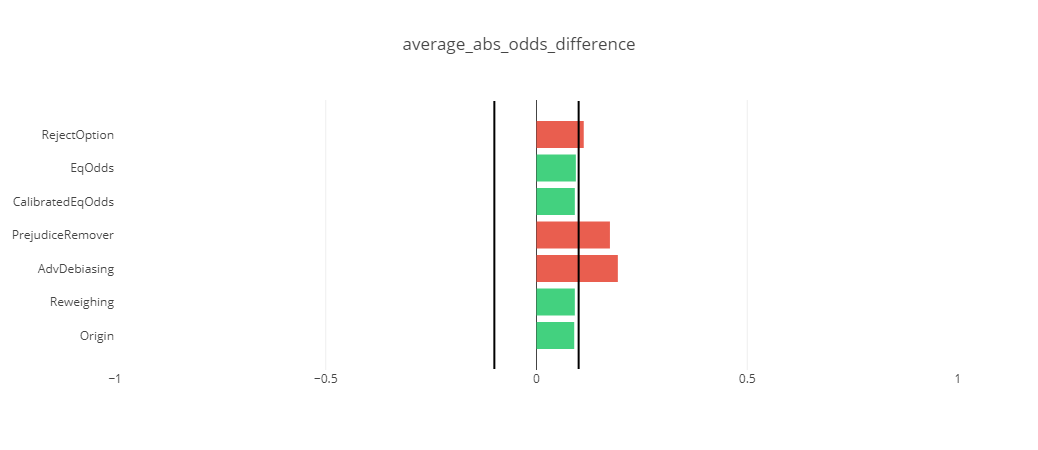

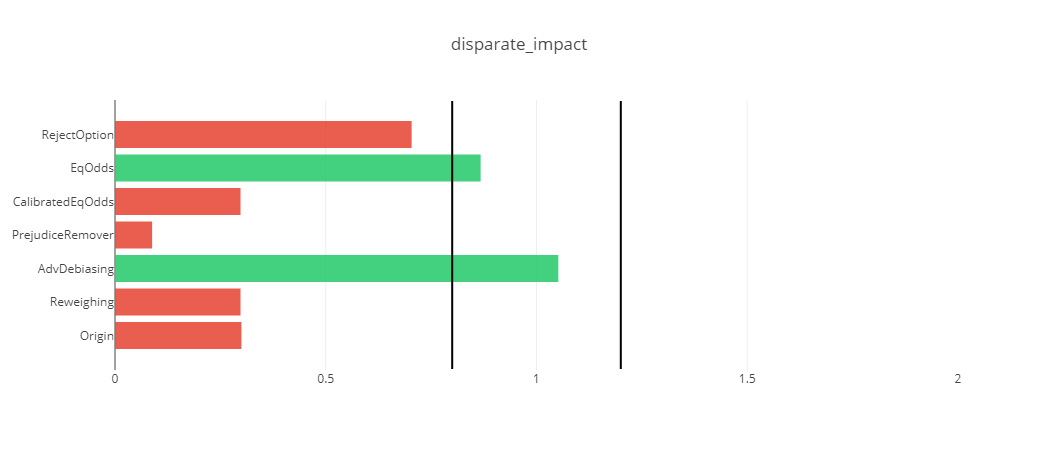

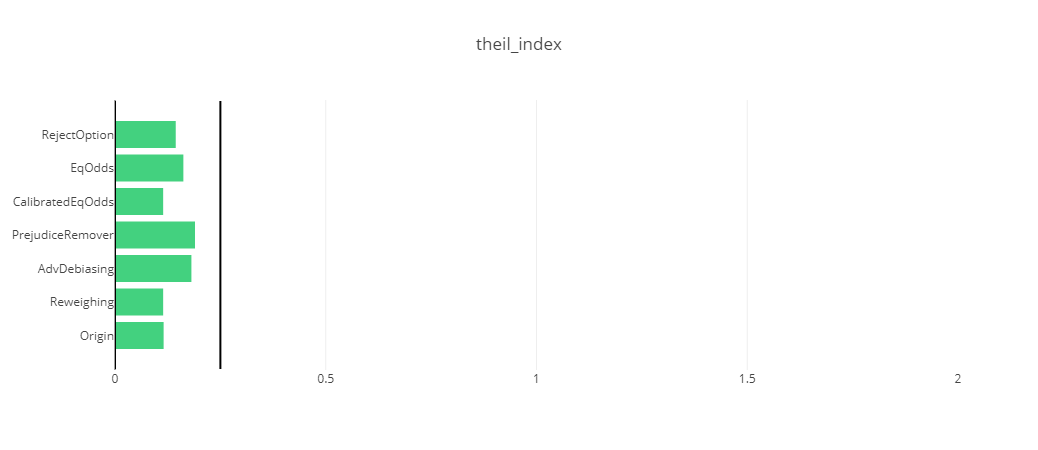

score  nb_valid
EqOdds            0.564246       4.0
AdvDebiasing      0.801477       3.0
RejectOption      0.818062       2.0
Origin            1.191246       2.0
Reweighing        1.197392       2.0
CalibratedEqOdds  1.197392       2.0
PrejudiceRemover  1.702411       1.0

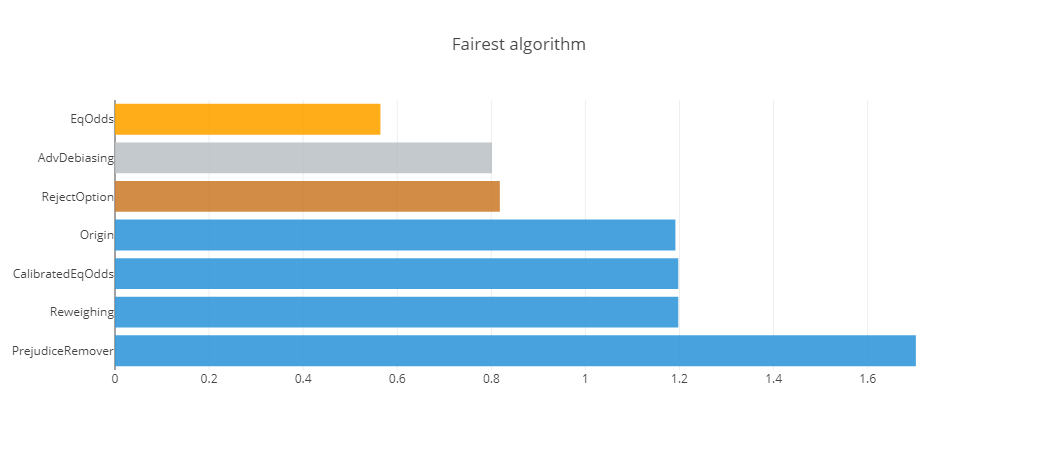

In [33]:
compare_fair_metrics(algo_metrics)

### <a id='3.4'>3.4 Find the fairest algorithm</a>

score  nb_valid
AdvDebiasing      1.878906       7.0
EqOdds            1.690256       6.0
RejectOption      2.173884       3.0
PrejudiceRemover  2.864285       3.0
Reweighing        2.874590       3.0
CalibratedEqOdds  2.874590       3.0
Origin            3.026361       3.0

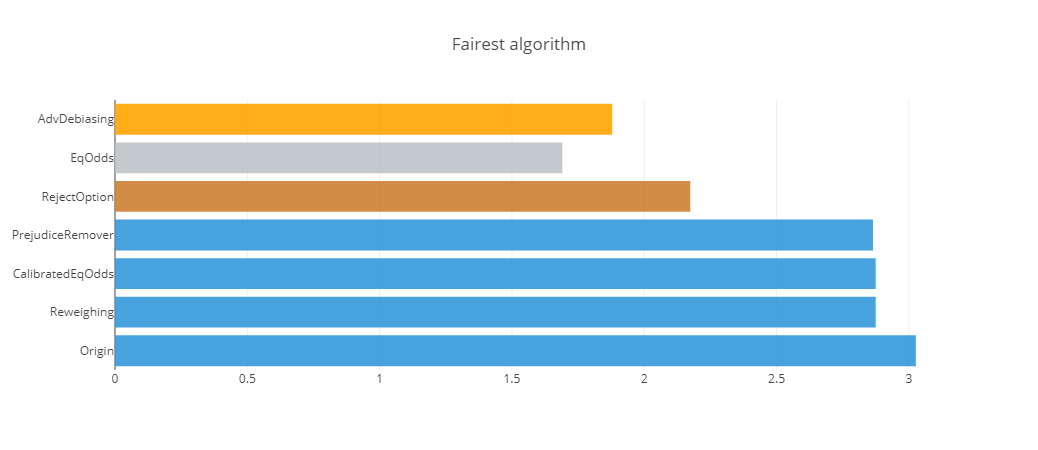

In [34]:
final = score_all_attr(algo_metrics)
plot_score_fair_metrics(final)

So now we see that it's the **EqOdds** algorithm that gives us the fairest model but it's not completly fair only 6 metrics for 10 valid the fair of the model, mostly for the *Race* column because we didn't unbias the column, but for the *Sex* column we can see that 4 metrics valid fair in the model so it's a great improvment ! 👍

Now let's compare our algorithm for the performance.

### <a id='3.5'>3.5 Compare algorithms performance</a>

Accuracy  F1 Score
Reweighing        0.860579  0.684868
CalibratedEqOdds  0.860579  0.684868
Origin            0.859760  0.682135
RejectOption      0.847477  0.609948
EqOdds            0.811854  0.544373
PrejudiceRemover  0.800491  0.458160

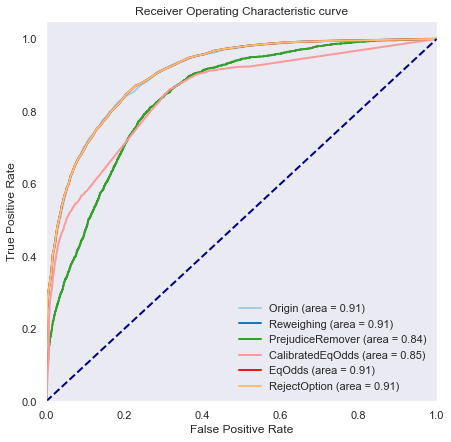

In [35]:
plot_compare_model_performance(algo_metrics, data_orig_test)

We can see that the original model still has a great accuracy and F1 Score. I remind you that here I didn't optimize the models to be excellent I used default configurations.

Now you have to ask yourself the question, **what is more important : performance or fair ?**

## <a id='4'>4. Interpretable model</a>
### <a id='4.1'>4.1 Feature importance</a>

The question of **model interpretation is becoming really important** and the most common way to explain a model is to use **feature importance**. It's usefull to get an insight of what the model is using in feature to predict something but it has limits. First of all let's see how it works.

Feature importance changes according to the model that we're using. It's important to know that **it exists differents ways to measure feature importance** according to the model so I will introduce some measure for 3 types of models : Linear Regression, Decision Tree and Tree models.

#### <a id='4.1.1'>4.1.1 Linear Regression</a>

For the Linear Regression if we have standardized the features the coefficient represents the influence of the feature on the model. So for a Linear model with a formula : 

$$h_\theta(X) = \theta_0x_0 + \theta_1x_1 + ... + + \theta_nx_n = \theta^TX$$

We can just take all the theta with the vector $\theta$ and it's our importance for each feature.

#### <a id='4.1.2'>4.1.2 Decision Tree</a>

For the Decision Tree, feature importance is not really important because this model is human interpretable. For a prediction you just have to follow the leaves.

#### <a id='4.1.3'>4.1.3 Tree models (e.g Random Forest)</a>

I think this type of models (Random Forest, XGBoost, LGBM, ...) is well known in the industry today so the feature importance of those models are logically the most used for classification. So the most used measure of feature importance for Tree models is **Gini Importance or Mean Decrease in Impurity (MDI)**. 

![Random Forest](https://cdn-images-1.medium.com/max/1000/1*xxahsU68wsbXyMYAFTf-Eg.png)

**MDI** counts the times a feature is used to split a node, weighted by the number of samples it splits.

We can calculate it with this formula :

$$Imp(X_j)=\frac{1}{M}\sum_{m=1}^{M}\sum_{t\in \varphi_m} (j_t=j)[p(t)\Delta i(t)]$$

Here we calculate the importance of variable $X_j$ for an ensemble of $M$ trees. $j_t$ denotes the variable used at node $t$, $p(t) = \frac{N_t}{N}$ is the proportion of rows used in that node (if it's the first node it will be 1) and $\Delta i(t)$ is the impurity reduction at node $t$ : we can use Gini index or Entropy to measure impurity.

I find out this formula from this course : [Understanding variable importances in forests of randomized trees](https://fr.slideshare.net/glouppe/understanding-variable-importances-in-forests-of-randomized-trees)

Also if you want more informations about others Tree models measure of feature importance you can take a look at this publication : [Feature Importance Measures for Tree Models — Part I](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3)

Now let's see what is the feature importance of our Random Forest model.

In [36]:
rf.feature_importances_
feature_imp = pd.Series(rf.feature_importances_, index=data_orig_train.feature_names)
feature_imp.sort_values(ascending=False, inplace=True)

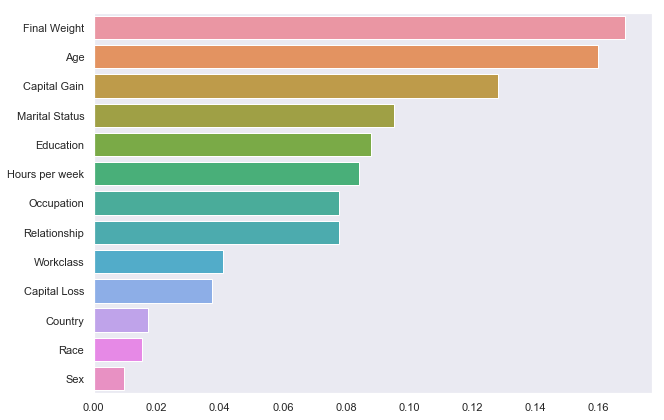

In [37]:
plt.figure(figsize=(10,7))
ax = sns.barplot(y=feature_imp.index.values, x=feature_imp,orient='h')

We see that *Final Weight*, *Age* and *Capital Gain* are the features that are the most importance for this model if we use feature importance from sklearn RandomForestClassifier. But now we arrive at **the limits of feature importance**, if I want to know wich feature are important on **a specific prediction** I can't know that I just can suppose that it follows the feature importance measure but I can not be sure.

### <a id='4.2'>4.2 LIME</a>
Source : [LIME GitHub repository](https://github.com/marcotcr/lime)

So with the objective to find out wich features are important for a specific prediction appear **LIME** : *Local interpretable model-agnostic explanations* it means that LIME can explain any models in Machine Learning. We can think it like the model is a black box that just have the input and output to find out what feature is important.

![LIME Black Box](https://cdn-images-1.medium.com/max/1000/1*k-rxjnvUDTwk8Jfg6IYBkQ.png)

To understand how it works we have to define it is important to distinguish between features and interpretable data representations. As mentioned before, interpretable explanations need to use a representation that is understandable to humans, regardless of the actual features used by the model. For example, a possible interpretable representation for text classification is a binary vector indicating the presence or absence of a word.

Now Let $f$ be the original prediction model to be explained and $g$ the explanation model such as a linear regression model. Here, we focus on local methods designed to explain a prediction $f(x)$ based on a single input $x$. Explanation models often use simplified inputs $x$ that map to the original inputs through a mapping function $x = h_x(x')$. Local methods try to ensure $g(z') ≈ f(h_x(z'))$ whenever $z' ≈ x'$ so it's a perturbed sample (Note that $hx(x') = x$ even though x may contain less information than $x$ because $h_x$ is specific to the current input $x'$).

The explanation model that is a linear function of binary variables that follows this formula :
$$g(z') = \phi_0 + \sum_{i=1}^{M}\phi_i z_i' $$

where $z' \in \{0, 1\}^M$, $M$ is the number of simplified input features, and $\phi_i \in R$

To find $\phi$, LIME minimizes the following **objective function** : 
$$ \xi =  \underset{g \in G}{arg min} \space L(f,g,\pi_{x'}) + \Omega(g) $$

Faithfulness of the explanation model $g(z')$ to the original model $f(h_x(z'))$ is enforced through the loss $L$ over a set of samples in the simplified input space weighted by the local kernel $\pi_{x'}$ (which calculate the distance between the perturbed sample and the original point). $\Omega$ penalizes the complexity of $g$. Since in LIME $g$ follows the linear equation above and $L$ is a squared loss, this equation can be solved using penalized linear regression.

So at the end we can obtain a explanation model like this : 

![Explanation model](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png)

Now let's use LIME on our dataset and original model (Random Forest).

In [38]:
# Convert AIF360 StandardDataset into a pandas DataFrame
test_interp = pd.DataFrame(data=data_orig_test.features,
                            columns=data_orig_test.feature_names)

categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country"]
categorical_features_idx = [np.where(test_interp.columns.values == col)[0][0] for col in categorical_features]
categorical_names_LIME = {}

for feature, idx in zip(categorical_features, categorical_features_idx):
    categorical_names_LIME[idx] = categorical_names[feature]
    
# Reverse the MinMaxScaler to get the original values back.
for feat in test_interp.columns.values:
    if feat in numerical_features:
        test_interp[feat] = encoders[feat].inverse_transform(np.array(test_interp[feat]).reshape(-1, 1))

In [39]:
# Initiate the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(test_interp.values,
                                                   feature_names=test_interp.columns.values,
                                                   class_names=['Income <= 50K', 'Income > 50K'],
                                                   categorical_features=categorical_features_idx, 
                                                   categorical_names=categorical_names_LIME)

We have the LIME explainer, we can see what results it gives us for 2 rows in the test set. 

#### First row

Relationship  Race  Sex  Education  Workclass  Occupation  Country  \
2           5.0   4.0  0.0       15.0        0.0         0.0     39.0   

   Hours per week  Marital Status  Capital Gain  Final Weight   Age  \
2            45.0             2.0           0.0      182687.0  62.0   

   Capital Loss  
2           0.0

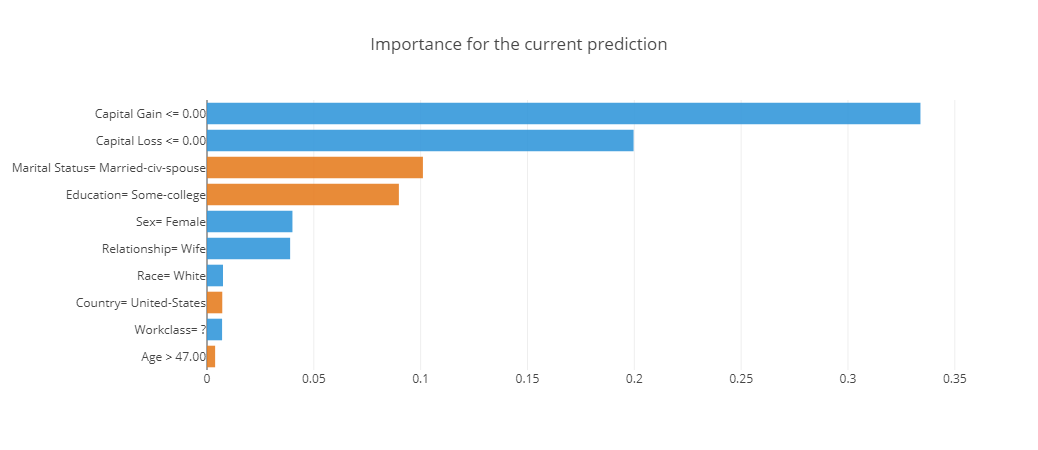

#### Second row

Relationship  Race  Sex  Education  Workclass  Occupation  Country  \
5           0.0   1.0  1.0       12.0        4.0         1.0     35.0   

   Hours per week  Marital Status  Capital Gain  Final Weight   Age  \
5            50.0             2.0           0.0       85995.0  60.0   

   Capital Loss  
5           0.0

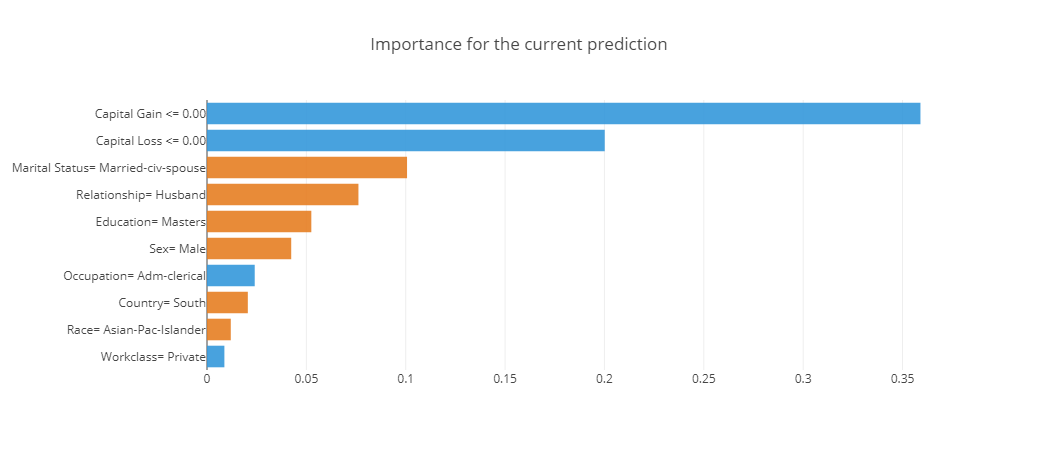

In [40]:
row_1 = pd.DataFrame(data=[test_interp.iloc[2,:]], columns=test_interp.columns.values)
row_2 = pd.DataFrame(data=[test_interp.iloc[5,:]], columns=test_interp.columns.values)
 
exp_1 = explainer.explain_instance(row_1.values[0], rf.predict_proba)
exp_2 = explainer.explain_instance(row_2.values[0], rf.predict_proba)

display(Markdown('#### First row'))
display(row_1)
# Plot function from LIME
exp_1.show_in_notebook(show_table=True, show_all=False)
# Custom plot function
plot_lime_importance(exp_1)

display(Markdown('#### Second row'))
display(row_2)
# Plot function from LIME
exp_2.show_in_notebook(show_table=True, show_all=False)
# Custom plot function
plot_lime_importance(exp_2)

As we can see LIME is performant to understand the importance of features for a specific prediction and if we want to get an understanding of the model can construct some aggregate values like a mean of all importance. 

I decided to construct to global metrics where $f$ is a feature and $M$ the number of elements : 
* Mean of the importance values : $\mu^f_{importance} = \frac{1}{M} \sum_{i=1}^{M} importance^f_i$
* Mean of the absolute of importance values : $\mu^f_{|importance|} = \frac{1}{M} \sum_{i=1}^{M} |importance^f_i|$

But to get this I have to regroup all the feature generate by LIME into the original feature. For example : it's possible to have a feature *Age > 10* and for another row *5 < Age < 24* so it needs to be just *Age* at the end.

In [41]:
def compute_mean(dataset):
    return dataset.mean()

def compute_mean_abs(dataset):
    return dataset.abs().mean()

t0 = time()
print('start : %0.4fs'%((time() - t0)))
    
importance = pd.DataFrame()

# I will just take a sample of set because it's a long operation on all the dataset.
test_lime = test_interp.iloc[0:1000,:]

for row in test_lime.values:
    exp = explainer.explain_instance(row, rf.predict_proba)
    feats = [x[0] for x in exp.as_list()]
    val = [x[1] for x in exp.as_list()]
    
    for i in range(0,len(feats)):
        for feat in test_lime.columns.values:
            if(feat in feats[i]):
                feats[i] = feat
    
    exp_df = pd.DataFrame(data=[val], columns=feats)
    importance = importance.append(exp_df)

print('end : %0.4fs'%((time() - t0)))

start : 0.0000s
end : 185.9988s


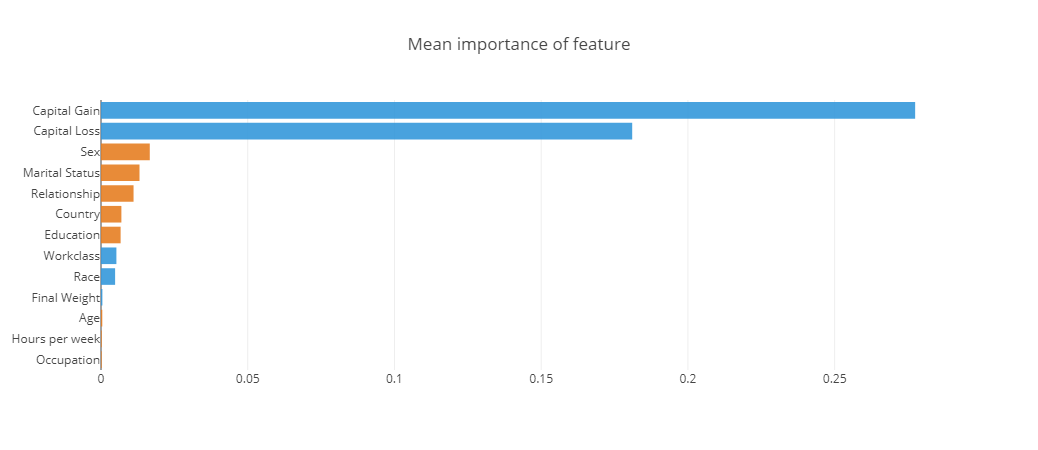

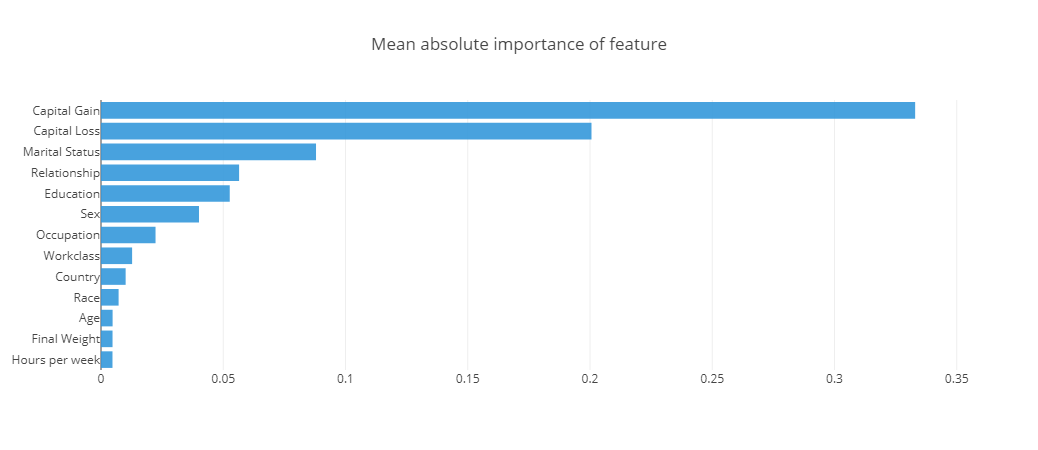

In [42]:
mean_imp = compute_mean(importance)
# Stock importance to compare it with other importance after
lime_importance = compute_mean_abs(importance)
plot_global_importance_lime(mean_imp, 'Mean importance of feature')
plot_global_importance_lime(lime_importance, 'Mean absolute importance of feature', True)

We can see that taking the mean is not relevant because we can loose some information so I prefer to use the second one with the absolute value.

Now you see how LIME works, but also it don't offer us the possibility to have a global value so it's not the best thing. But just one year after LIME another library appeared : **SHAP**, they proposed an alternative kernel from the LIME method and claims that only its approach can satisfy three key axioms of interpretability. 

### <a id='4.3'>4.3 SHAP</a>
Source : [SHAP GitHub repository](https://github.com/slundberg/shap)

As I said before SHAP claims that it satisfy three axioms of interpretability. But, before going into the theory of SHAP let's dive into the **game theory**.

Let's ask ourselves a question : *in a coalition that is composed of multiple players with differing skill sets, that results in some collective payoff, what is the fairest way to divide up that payoff among the players ?*. With this question we will find out the Shapley values. 

#### <a id='4.3.1'>4.3.1 Shapley Values</a>
What is this value ? Before going into theory I need to use an example to have a better understanding about this value. 

Let's take 2 persons : Bob and Alice. They are going to a restaurant but at the end how will they split the bill ? To get the answer in a first place we need to know how much they spend if they were alone and together. Let's say that Bob alone would spend 50€ , Alice would spend 30€ and together 70€. So we can have the following information :
$$  v(c) = 
\begin{cases}
50, \ \text{if} \ c=\{\text{Bob}\} \\ 
30, \ \text{if} \ c=\{\text{Alice}\} \\ 
70, \ \text{if} \ c=\{\text{Bob & Alice}\}
\end{cases} $$

Now we have to know what they pay each depending on the order of arrive, for example if Alice arrives first she paid 30€ and then Bob paid the difference between what they pay together and what Alice paid so 40€. We denote $\pi$ the order of arrival and $\delta_{\pi}^G$ what they pay each depending on the order of arrival. So now we obtain this :

$$
\begin{array}{c c}
\pi & \delta_{\pi}^G \\
\hline 
(\text{Bob}, \text{Alice}) & (\text{Bob}:50,\text{Alice}:20) \\
(\text{Alice}, \text{Bob}) & (\text{Bob}:40,\text{Alice}:30) \\
\end{array}
$$

And now to obtain the Shapley values $\phi$ we just have to get the mean on each person from $\delta_{\pi}^G$ :

$$ \phi = (\text{Bob}:45,\text{Alice}:25) $$

So the concept of this value is not that complicated and now here is the formula that get us the values : Here $|F|$ is the size of the full coalition. $S$ represents any subset of the coalition that doesn’t include player $i$, and $|S|$ is the size of that subset. The bit at the end is just "how much bigger is the payoff when we add player $i$ to this particular subset $S$"

$$ \phi_i = \sum_{S\subseteq F\setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \{i\}}(x_{S\cup \{i\}}) - f_S(x_S)]$$

So this values satisfy the 3 following axioms of interpretability :
* *Dummy Player* : If a player never adds any marginal value, their payoff portion should be 0.
* *Substitutability* : If two players always add the same marginal value to any subset to which they’re added, their payoff portion should be the same.
* *Additivity* : If a game is composed of two subgames, you should be able to add the payoffs calculated on the subgames, and that should match the payoffs calculated for the full game.

#### <a id='4.3.2'>4.3.2 How SHAP works</a>

SHAP which means *SHapley Additive exPlanations*, uses both **game theory** (with Shapley value) and **local interpretation** (with LIME). But how it do that ? 

They used the concept of simplifed feature with vector includes in {0,1} and they defined the 3 axioms but in mathematicals terms so *Dummy player* become *Missingness*, *Substitutability* become *Local accuracy* and *Additivity* become *Consistency* (more informations about this mathematicals formulas in [the SHAP paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)).

And with that we obtain the following formula : Here $f$ is the original model for some specific inputs $x$, and $x'$ is the simplified input (which corresponds to the original input $x$), $M$ is the full number of features and $z'$ is a sample of $x'$.

$$ \phi_i(f,x) = \sum_{z'\subseteq x'} \frac{|z'|!(M-|z'|-1)!}{M!} [f_x(z') - f_x(z'\setminus i)]$$

So we see that is the **same logic than the Shapley value** but here instead of **players** we have **features**. 

The following text is from the SHAP paper, it explains the conection between the formula of LIME and the one juste above : 
> At first glance, the regression formulation of LIME in Equation 2 seems
very different from the classical Shapley value formulation of Equation 8. However, since linear
LIME is an additive feature attribution method, we know the Shapley values are the only possible
solution to Equation 2 that satisfies Properties 1-3 – local accuracy, missingness and consistency. A
natural question to pose is whether the solution to Equation 2 recovers these values. The answer
depends on the choice of loss function $L$, weighting kernel $\pi_{x'}$ and regularization term $\Omega$. 

So to satisfy the 3 properties there is juste one combination of parameters that need to be follow :

$
\Omega(g) = 0, \\
\pi_{x'}(z') = \frac{(M-1)}{(M \ choose \ |z'|)|z'|(M-|z'|)}, \\
L(f,x,\pi_{x'}) = \sum_{z'\in Z}[f(h_x(z')) - g(z')]^2 \pi_{x'}(z')
$

And this is how it works theoretically now let's practice with the library in Python.
*****

#### <a id='4.3.3'>4.3.3 SHAP in Python</a>
First let's generate the explainer with the `RandomForestClassifier` from sklearn.

In [43]:
t0 = time()
print('start : %0.4fs'%((time() - t0)))

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)
print('explainer end : %0.4fs'%((time() - t0)))

# Calculate Shap values
test_shap = test_interp.copy()
# shap_values = explainer.shap_values(test)
shap_values = explainer.shap_values(test_shap)
print('shap values end : %0.4fs'%((time() - t0)))

start : 0.0000s
explainer end : 0.0868s
shap values end : 416.2492s


Now we have our shap values for each possible class (here : Income <= 50K or Income > 50K) and for each features / rows. SHAP provides us some plot function, especially one that plot shap values for a prediction : `shap.force_plot()`. It shows us the evolution between the *base value* $E[f(z)]$, which is the probability of a prediction if do not know any feature, and the current prediction $f(x)$

![SHAP values attribute](http://image.noelshack.com/fichiers/2018/50/5/1544793324-shap-values.png)

Now let's see how it looks like on a random row of our test set.

In [44]:
def plot_shap_explain(data, idx, model, explainer, shap_values, categorical_features=None, encoders=None):
    row = data.iloc[idx,:] 
    display(pd.DataFrame([row.values], columns=row.index))
    proba = model.predict_proba([row])[0]
    display(Markdown("Probability of having an Income <= 50K : **%0.2f**"%proba[0]))
    display(Markdown("Probability of having an Income > 50K : **%0.2f**"%proba[1]))
    
    if categorical_features != None:
        for feature in categorical_features:
            row[feature] = encoders[feature].inverse_transform([int(row[feature])])[0]
    
    display(Markdown("#### Explaination based on the 0 label (Income <= 50K)"))
    display(shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], row))
    display(Markdown("#### Explaination based on the 1 label (Income > 50K)"))
    display(shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], row))

# Take a random index
random_index = np.random.randint(0, len(test_shap))

shap.initjs()
plot_shap_explain(test_shap, random_index, rf, explainer, shap_values, categorical_features, encoders)

Relationship  Race  Sex  Education  Workclass  Occupation  Country  \
0           0.0   4.0  1.0       12.0        1.0         4.0      9.0   

   Hours per week  Marital Status  Capital Gain  Final Weight   Age  \
0            40.0             2.0           0.0       39606.0  46.0   

   Capital Loss  
0           0.0

Probability of having an Income <= 50K : **0.43**

Probability of having an Income > 50K : **0.57**

#### Explaination based on the 0 label (Income <= 50K)

#### Explaination based on the 1 label (Income > 50K)

Now like feature importance and the custom metrics from LIME we need to see what is the global measure on the model. So SHAP gives us a plot function `shap.summary_plot()` which gives us 2 possible plot : bar plot or dot plot.

The *bar* plot calculate the average absolute SHAP value and display a bar chart like the one for feature importance. The *dot* plot sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

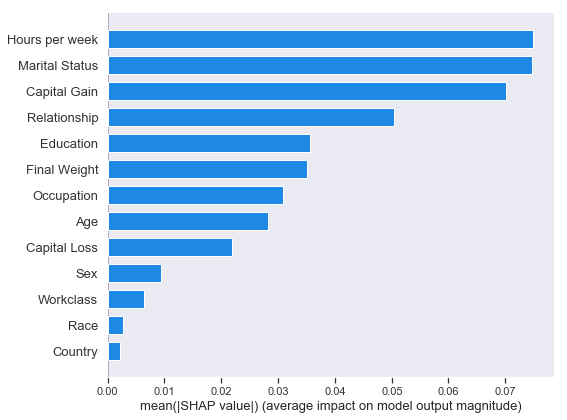

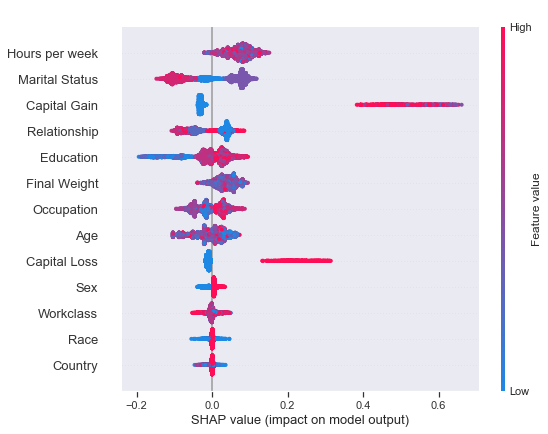

In [45]:
shap.summary_plot(shap_values[1], test_shap, test_shap.columns.values, plot_type='bar')
shap.summary_plot(shap_values[1], test_shap, test_shap.columns.values, plot_type='dot')

Here the seconde plot reveals that, for example, More *Capital Gain* is high, higher is the chance that the model predicted an Income > 50K.

Before concluding this part I will just keep the importance to compare it after.

In [46]:
shap_df = pd.DataFrame(data=shap_values[1], columns=test_shap.columns)
shap_importance = compute_mean_abs(shap_df)

Now you have a quick overview of the SHAP library but I just used the `TreeExplainer` and there are other explainers like explainer for neural networks so if you are curious don't hesitate to look on the GitHub repository or the SHAP paper.

### <a id='4.4'>4.4 Compare importance</a>

So to conclude this part let's see what each measure of importance say and which one we can use to explain our model.

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



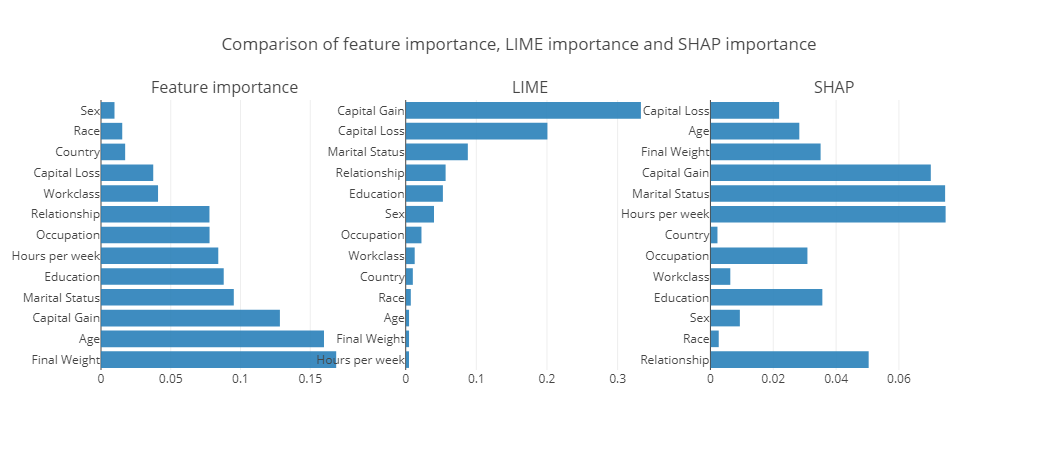

In [47]:
def get_trace(series, color='#2980b9'):
    series.sort_values(ascending=True)
    x, y = series.values, series.index
    trace = go.Bar(x=x, y=y, marker=dict(color=color), opacity=0.9, orientation='h')
    return trace

trace1 = get_trace(feature_imp)
trace2 = get_trace(lime_importance)
trace3 = get_trace(shap_importance)

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=('Feature importance', 'LIME','SHAP'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig['layout'].update(title='Comparison of feature importance, LIME importance and SHAP importance',
                     showlegend=False,
                     yaxis=go.layout.YAxis(automargin=True),
                     barmode='group')
py.iplot(fig)

We see that they are different results so how to decide which one to trust. The answer is : **SHAP** because it's not just the mathematics that are behind this method also they study the importance found with human intuition and here is their results :

![Comparison between LIME, SHAP and human for importance](http://image.noelshack.com/fichiers/2018/50/5/1544800972-shap-lime-human.png)

This image shows us the human intuition correspond to what SHAP determine.

Thanks for reading ! 👍